# Orthogonal Matching Pursuit demostration

We start by importing the necessary standard libraries, the Orthogonal Matching Pursuit algorithms (DCT and Gabor dictionaries implementation) and some helper functions. 

In [1]:
import os
import librosa
import numpy as np
import scipy as sp
import soundfile as sf
import matplotlib.pyplot as plt

from omp import OMP_C, OMP_G
from helpers import next_multiple, define_reliable_support

In order to tackle all the preprocessing steps needed before calling the algorithm, namely: the creation of the dictionaries, the frame-based processing and the overlap-add method an utilitary function was built. Its comments explain what is being done in each step.

In [2]:
def invoke_OMP(file, audio, fs, dictionary, mode, verbose):
    '''
    invoke_OMP
    Utilitary function to call the Orthogonal Matching Pursuit (OMP) algorithm and return the audio signal estimation.
    
    Parameters
    file: File name.
    y: Signal to estimate.
    fs: Sample rate of the signal.
    D: Toggles the DCT or DGT dictionaries. Takes 'D' or 'G' as values, respectively.
    mode: Whether to enforce the unconstrained ('normal') or the minimum constrained ('min') problem.
    verbose: Toggles verbosity.
    '''
    
    # The chosen frame length is 64 ms as defined by manual setting in the paper. 
    # Thus, we multiply the sample rate times 64 ms in order to obtain the number of samples per frame.
    N = int(fs * 64e-3)
    N_support = np.arange(N)

    # In order to make frame-based processing possible we need to pad with zeros the original audio vector. 
    # Thereforex, we need to change its length.
    L = next_multiple(len(audio), N)
    audio = np.pad(audio, (0, L - len(audio)))

    # The clipping level is obtained from considering the infinity norm of the audio vector. 
    CLIP_LEVEL = max(audio)
    
    # We assign a different value to the frequency bins K variable depending on what dictionary we are working on.
    if dictionary =='C':
        K = N * 2
        K_support = np.arange(K)

    elif dictionary =='G':
        K = N
        K_support = np.arange(K)

    ''' Dictionary '''
    
    # We will use a rectangular window for the dictionary and as the analysis window per frame.
    w = np.ones(N)

    # DCT.
    if dictionary =='C':
        # Memory allocation for the dictionary.
        D = np.empty((N, K))
        
        # Now we gradually complete each column of the dictionary through iteration for each case.
        for j in K_support:
            D[:, j] = w * np.cos((np.pi / K) * (N_support + 1/2) * (j + 1/2))

    # Gabor.
    elif dictionary =='G':
        D = np.empty((N, 2 * K))
        
        for j in K_support:
            D[:, j] = w * np.cos((np.pi / K) * (N_support + 1/2) * (j + 1/2))
            D[:, j + K] = w * np.sin((np.pi / K) * (N_support + 1/2) * (j + 1/2))

    ''' Frame-based processing '''

    # In order to achieve 75% overlap, the offset distance (hop size) must be of N / 4.
    R = N // 4
    R_support = np.arange(0, L - N + 1, R)

    # The total number of frames is obtained.
    frames = len(R_support)

    # The memory allocation for the matrix that will contain each of the frames is performed.
    Y = np.empty((N, frames))

    # The rectangular window is applied and each frame is assigned to the matrix Y.
    for i, r in enumerate(R_support):
        Y[:, i] = w * audio[r:r+N]

    # We will also generate the measurement matrix M from an identity matrix of dimension N x N.
    M = np.identity(N)

    # Memory allocation for the matrix that will contain the processed frames.
    # DCT.
    if dictionary =='C':
        X_k = np.empty((K, frames))

    # Gabor.
    elif dictionary =='G':
        X_k = np.empty((2 * K, frames))

    print('OMP - filename: {}, dictionary: {}, mode: {}'.format(file, dictionary, mode))
    
    # From here on, we will process each frame independently and put it in each column of the matrix X_k.
    for i in np.arange(frames):
            if verbose: print('\nframe number: {}'.format(i))

            # Frame assignment.
            y = Y[:, i]

            # The support of the reliable samples I_r. 
            # It is obtained through finding the samples where the clipping level is not reached.
            I_r = define_reliable_support(y, CLIP_LEVEL)
            
            # The reliable samples support vector is used to obtain the reliable samples vector.
            y_r = y[I_r]

            # The support of the missing samples I_m.
            # Conversely, It is obtained through finding the samples that result in the 
            # absolute value of the clipping level when evaluated in the signal.
            I_mp = np.where(y == CLIP_LEVEL)[0]
            I_mn = np.where(y == - CLIP_LEVEL)[0]
            
            # Measurement matrices are built upon the support vectors also.
            M_r = M[I_r]
            M_mp = M[I_mp]
            M_mn = M[I_mn]

            # The error threshold will be set to 1e-6. 
            epsilon = 1e-6

            # Further, we multiply this value for the amount of elements in the reliable samples support vector.
            epsilon_omp = epsilon * len(I_r)

            # The maximum sparsity level is defined. 
            # Floor division is used to keep the result as an integer and make comparison operators work more efficiently.
            K_omp = N // 4

            # The OMP algorithm is called.
            if dictionary =='C':
                x_k = OMP_C(y_r, M_r, M_mp, M_mn, D, K_omp, epsilon_omp, CLIP_LEVEL, mode=mode, verbose=verbose)
            elif dictionary =='G':
                x_k = OMP_G(y_r, I_r, M_r, M_mp, M_mn, D, K_omp, epsilon_omp, CLIP_LEVEL, mode=mode, verbose=verbose)

            # After execution, we store the sparse representation into the previously allocated in memory matrix X_k.
            X_k[:, i] = x_k

    ''' Overlap-Add Method '''
    
    # Memory allocation of a list that will contain the processed signal and another that will contain a sum of windows.
    proc_audio = np.zeros(L)
    proc_w_sin = np.zeros(L)
    
    # A sine window is used as the synthesis window.
    w_sin = sp.signal.windows.cosine(N)

    # The signal is restored using the overlap-add method by definition.
    for x_k, r in zip(X_k.T, R_support):
        proc_audio[r:r+N] = proc_audio[r:r+N] + D.dot(x_k) * w_sin
        proc_w_sin[r:r+N] = proc_w_sin[r:r+N] + w_sin

    proc_audio = proc_audio / proc_w_sin

    return proc_audio

As the above function only takes one signal at the time, a small script was written in order to load all audio signals and execute the declipping algorithms in a gradual fashion. Keep in mind that you need the signal directory in order to execute the next cell and that it takes about 5 minutes per second of signal estimation (~25 minutes per signal) on an average computer.

In [ ]:
''' Signal processing '''

# The needed variables are initialized.
verbose = False
path = './signal/clipped/'

original_signals = []
clipped_signals = []
d_m = []

# A list with audio file names is created.
files = os.listdir(path)

# We proceed to load our clipped audio signals.
for file in sorted(files):
    if file[-4:] == '.wav':
            [audio, fs] = librosa.load(path + file, sr=None) 
            clipped_signals.append((file, audio, fs))

# Tuples are used to store all possible parameter combinations.
for dictionary in ['C', 'G']:
    for mode in ['normal', 'min']:
        d_m.append((dictionary, mode))
   
# Finally, we call the declipping algorithm through the invoke_OMP utilitary function and create an audio .wav file with the generated audio signal estimation.
i = 0
for signal in clipped_signals:
    for (dictionary, mode) in d_m:
        
        file = signal[0]
        audio = signal[1]
        fs = signal[2]
        
        y = invoke_OMP(file=file, audio=audio, fs=fs, dictionary=dictionary, mode=mode, verbose=verbose)
        file = file.replace('.wav','',1)
        sf.write('de'+file+'_'+'OMP'+dictionary+'_'+mode+'.wav', y, fs)
        i += 1
        print(i)

In [3]:
%%latex

In order to prove which of the algorithms makes the best estimation in terms of quality, we compare them using the Signal-to-Noise ratio $\mathbf{SNR}$. This parameter provides a good measurement of the global restoration of the signal. 

<IPython.core.display.Latex object>

Four different algorithms were tested on several clipping levels of a musical signal at a sample rate of 16 kHz. The first two algorithms (namely, the 'OMP C normal' and 'OMP G normal' algorithms) use the sparse representation framework with the DCT and Gabor transform to solve the audio inpainting problem, where the degraded samples are considered missing and the estimated signal is the result of a least-squares projection. 

On the other hand, the 'OMP C min' and 'OMP G min' algorithms also use the same **dictionaries**, namely the matrices of elementary signals comprised by the respective transforms, but solve the audio declipping problem instead, where the information about the clipping level is added to the model in order to improve the estimation.

The plots below show how the declipping algorithms work in the first five frames of the audio. It can be clearly seen that the Gabor transform does a better job in declipping that its DCT counterpart. The fifth frame is an example of that, here the Discrete Cosine Transform of the constrained algorithm produces a lot of noise while the minimum constrained Gabor transform provides a good estimate of the original signal.

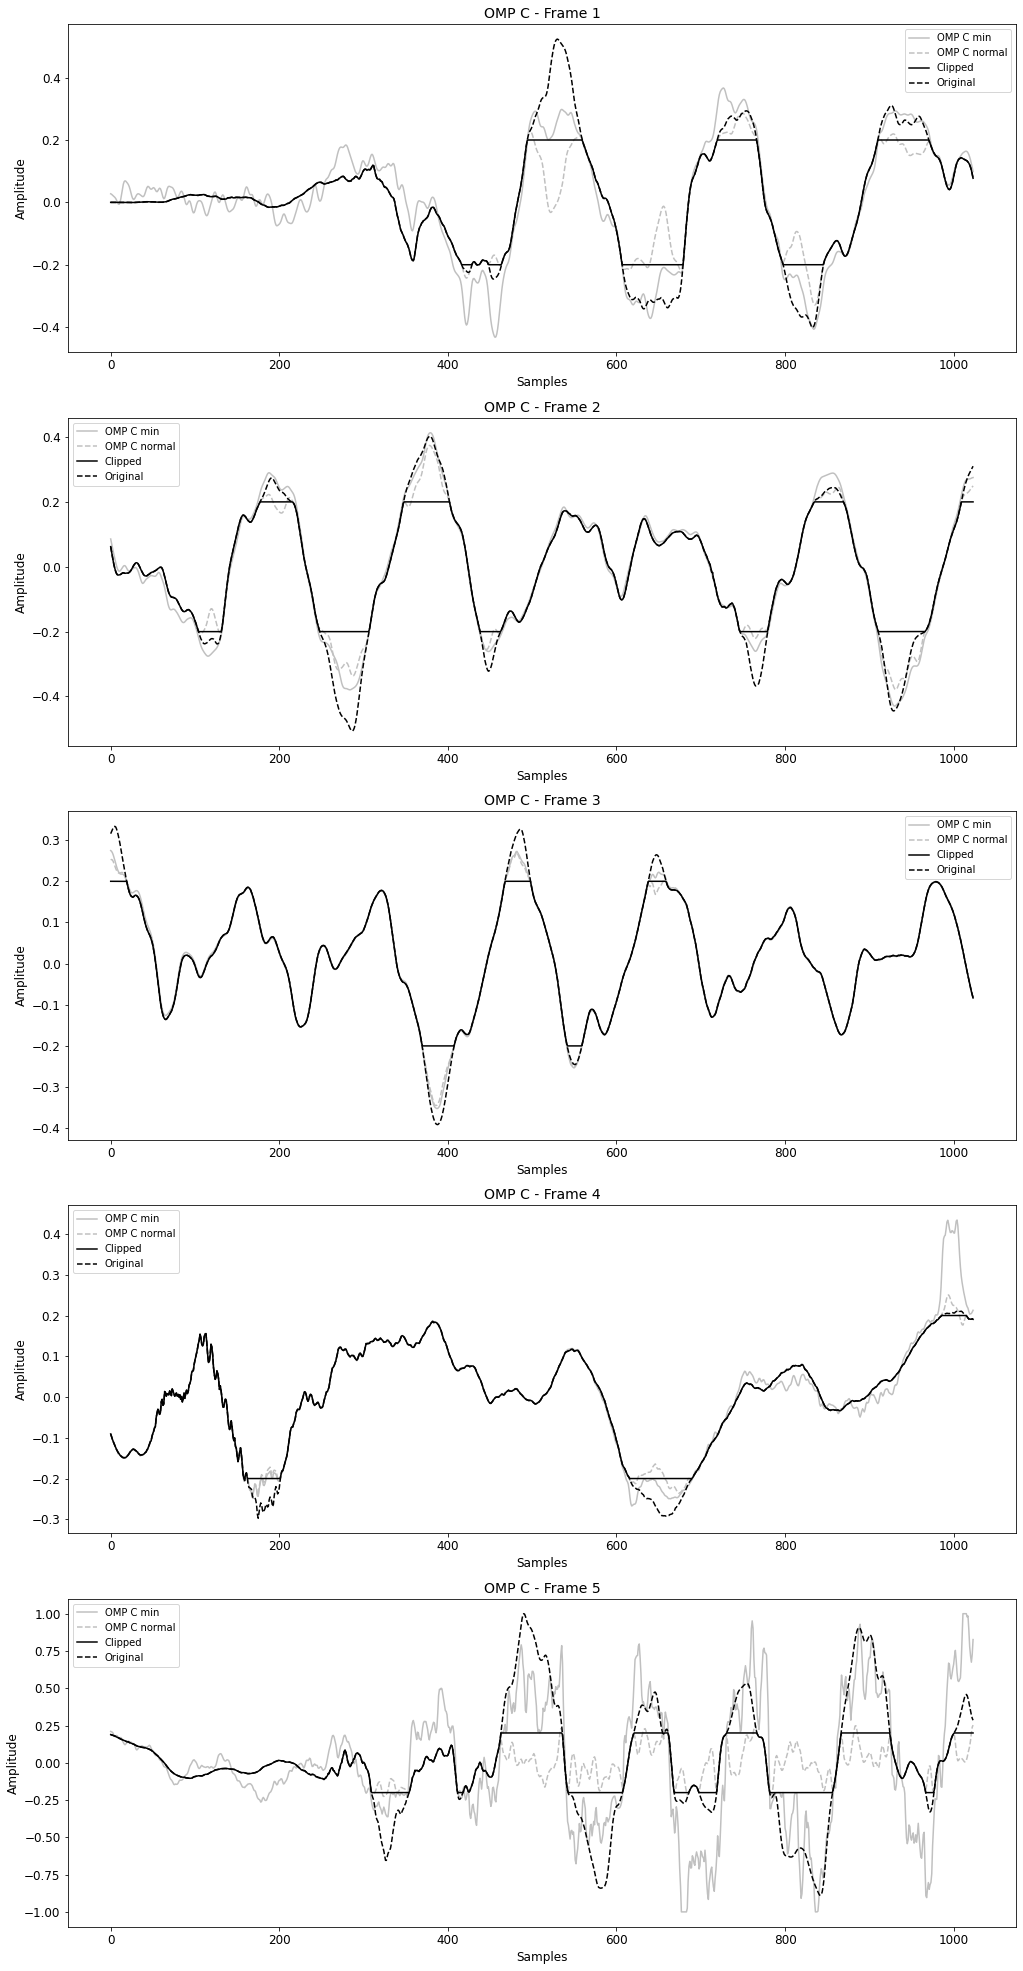

In [4]:
# DCT.
dct = np.load('dct.npy', allow_pickle=True).item()

# Frame length.
N = 1024

# We want the first five frames.
step = np.arange(0, 5 * N, N)

# Plots.
colors = ['silver', 'silver', 'black', 'black']
linestyles = ['-', '--', '-', '--']

fig, axes = plt.subplots(5, 1, figsize=(17, 35))

for i, (r, ax) in enumerate(zip(step, axes.ravel())):
    for audio, col, lin in zip(dct.values(), colors, linestyles):
        ax.plot(audio[r:r+N], color=col, linestyle=lin)
        ax.set_xlabel('Samples', fontsize=12)
        ax.set_ylabel('Amplitude', fontsize=12)
        ax.tick_params(axis="both", labelsize=12)
        ax.set_title(f"OMP C - Frame {i+1}", fontsize=14)
        ax.legend(dct.keys(), fontsize=10)

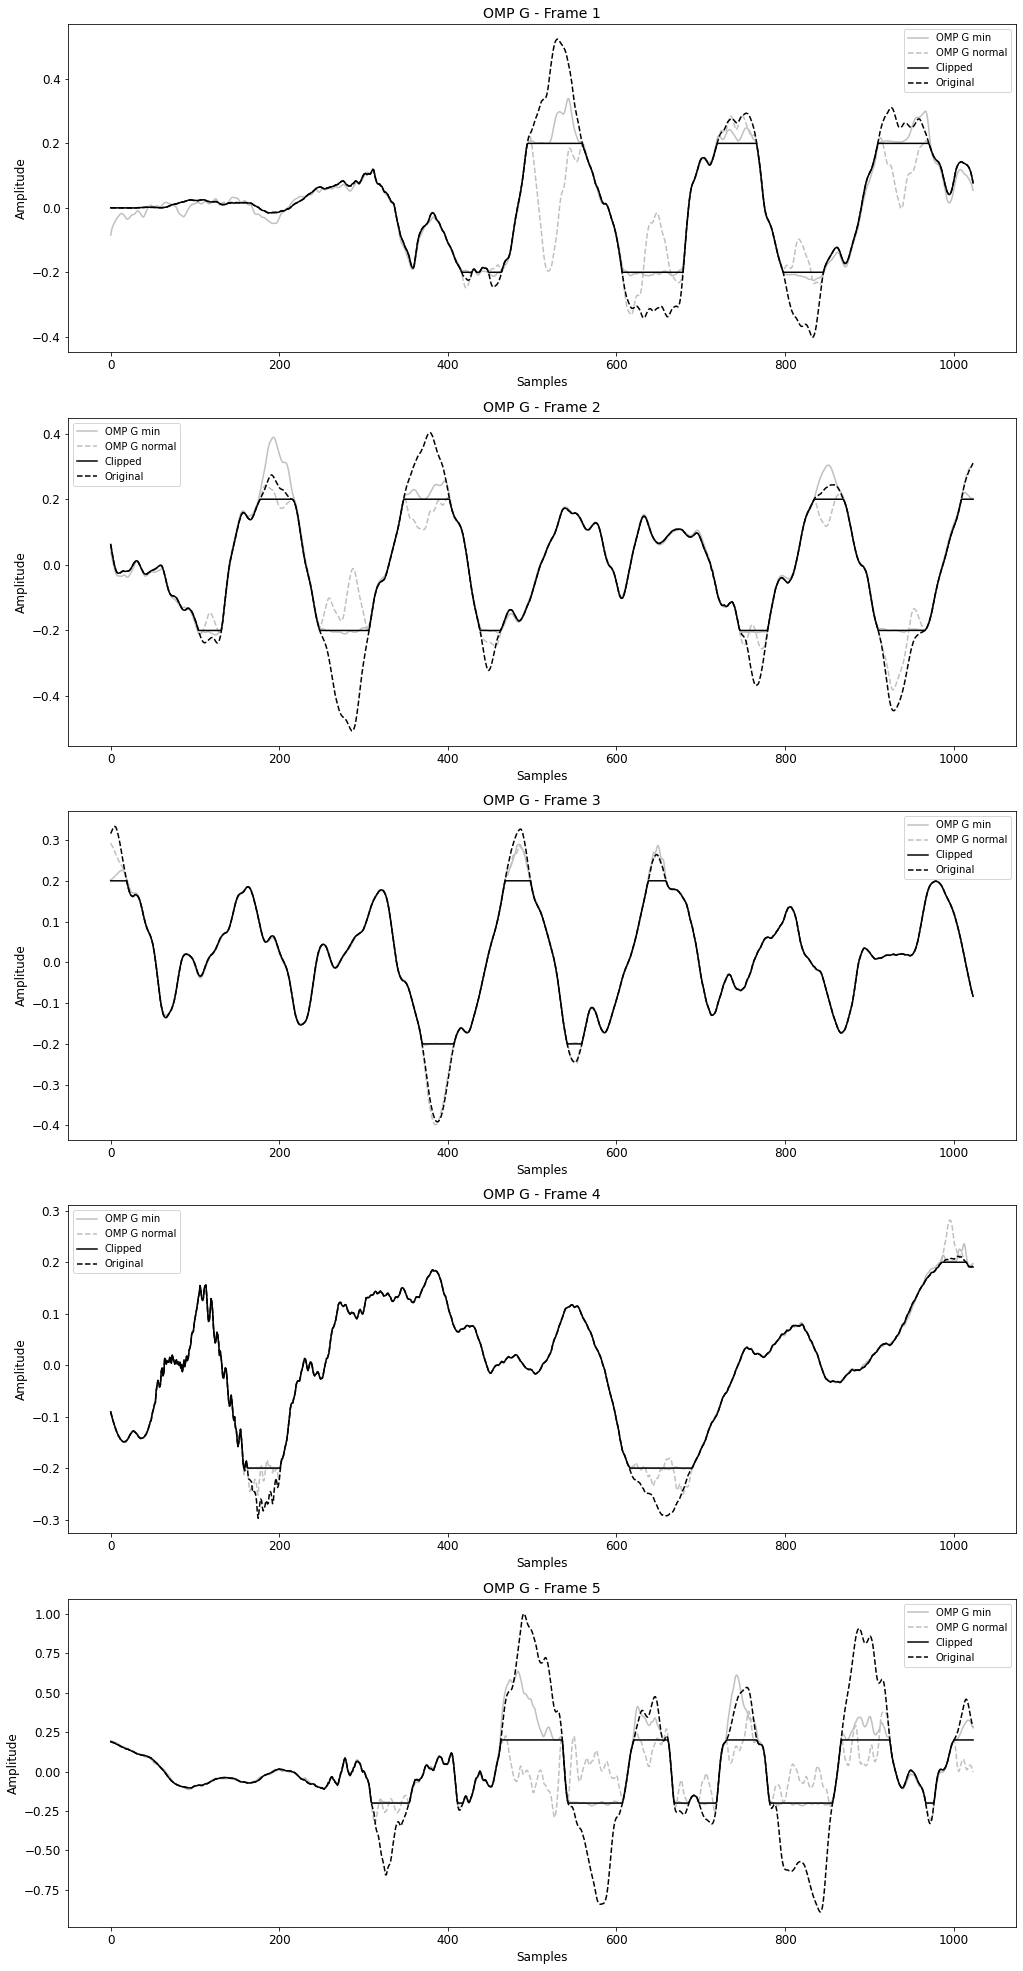

In [5]:
# DGT.
dgt = np.load('dgt.npy', allow_pickle=True).item()

legends = []

fig, axes = plt.subplots(5, 1, figsize=(17, 35))

for i, (r, ax) in enumerate(zip(step, axes.ravel())):
    for audio, col, lin in zip(dgt.values(), colors, linestyles):
        ax.plot(audio[r:r+N], color=col, linestyle=lin)
        ax.set_xlabel('Samples', fontsize=12)
        ax.set_ylabel('Amplitude', fontsize=12)
        ax.tick_params(axis="both", labelsize=12)
        ax.set_title(f"OMP G - Frame {i+1}", fontsize=14)
        ax.legend(dgt.keys(), fontsize=10)

Next, we will obtain the Signal-to-Noise ratio of the signals under study in order to provide a quantitative measurement that will allow us to compare the different algorithms. 

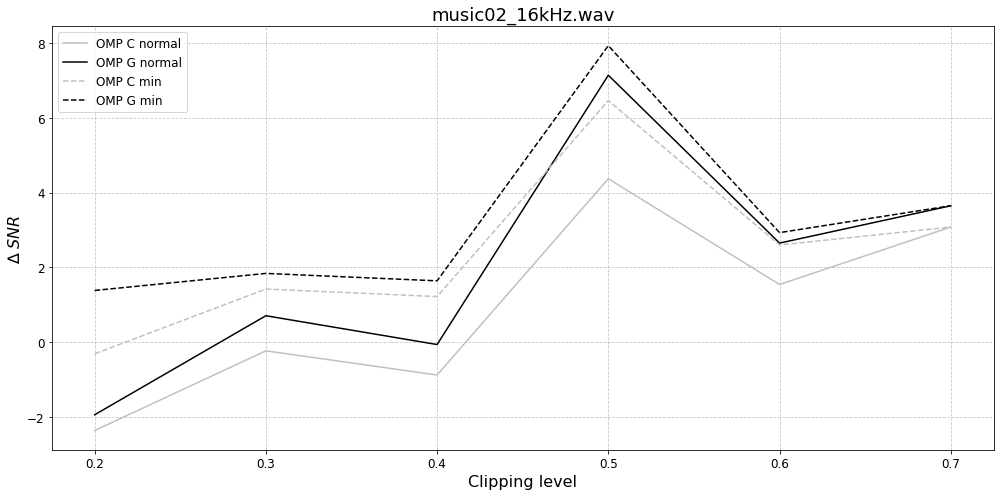

In [6]:
SNR = np.load('snr.npy')

# Plots

x = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

legends = ['OMP C normal', 'OMP G normal', 'OMP C min', 'OMP G min']

colors = ['silver', 'black', 'silver', 'black']
linestyles = ['-', '-', '--', '--']

plt.figure(figsize=(14, 7))

plt.title('music02_16kHz.wav', fontsize=18)
plt.xlabel('Clipping level', fontsize=16)
plt.ylabel('∆ $SNR$', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for i, col, lin in zip(np.arange(4), colors, linestyles):
    plt.plot(x, SNR[:,i], linestyle=lin, color=col)
plt.grid(b=True, which='major', linestyle='--', alpha=0.7)
plt.legend(['OMP C normal', 'OMP G normal', 'OMP C min', 'OMP G min'], fontsize=12, loc='upper left')

plt.tight_layout()

All the values of the previous plot are referenced to the Signal-to-Noise ratio of the clipped signal for each clipping level, which constitutes the 0 dB level. At a first glance, we can clearly see that the Gabor dictionary performs better in both versions of the algorithms (inpainting and declipping). This is because the Gabor dictionary considers the phase component of the audio signals in the resulting sparse representations whereas the Discrete Cosine Transform combines a group of cosine functions with zero phase.

In [7]:
%%latex

Alternatively, we can also consider the Signal-to-Noise ratio of the missing or clipped samples $\mathbf{SNR}_m$. This objective parameter depends solely on the result of the algorithm and is obtained from $\mathbf{SNR}$.

<IPython.core.display.Latex object>

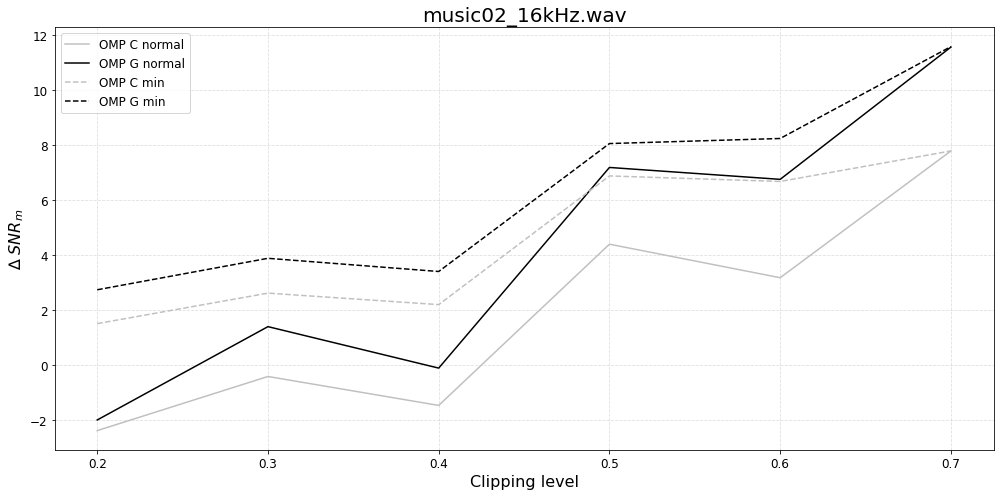

In [8]:
SNR_m = np.load('snr_m.npy')

plt.figure(figsize=(14, 7))

plt.title('music02_16kHz.wav', fontsize=20)
plt.xlabel('Clipping level', fontsize=16)
plt.ylabel('∆ $SNR_m$', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for i, col, lin in zip(np.arange(4), colors, linestyles):
    plt.plot(x, SNR_m[:,i], linestyle=lin, color=col)
plt.grid(b=True, which='major', linestyle='--', alpha=0.4)
plt.legend(['OMP C normal', 'OMP G normal', 'OMP C min', 'OMP G min'], fontsize=12)

plt.tight_layout()

In [9]:
%%latex

Finally, this plot shows a possible a correlation between the $\mathbf{SNR_m}$ and the clipping level of the signals that reflects the improvement on the resulting audio signal estimation as the clipping levels increments.

<IPython.core.display.Latex object>

#### References

[1] Adler, A., Emiya, V., Jafari, M. G., Elad, M., Gribonval, R., & Plumbley, M. D. (2011, May). A constrained matching pursuit approach to audio declipping. In 2011 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) (pp. 329-332). IEEE.